In [1]:
# Let's import some libraries. You don't have to modify anything here.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import skimage
import skimage.filters
import tensorflow as tf
import math
import random
import numpy as np
from scipy.stats import norm
import pylab as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import os
import glob
from functools import partial
from IPython.display import display, clear_output
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from PIL import Image
from tqdm import tqdm
import time

torch.set_default_dtype(torch.float32)
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cpu')

# use gpu acceleration if that is possible 
cuda = torch.cuda.is_available()
if cuda:
    torch.cuda.manual_seed(42)
    device = torch.device('cuda')

input_shape = (400, 400)  # (h, w)

In [79]:
from math import exp



def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()


def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window


def ssim(img1, img2, window_size=11, window=None, size_average=True, full=False, val_range=None):
    # Value range can be different from 255. Other common ranges are 1 (sigmoid) and 2 (tanh).
    if val_range is None:
        if torch.max(img1) > 128:
            max_val = 255
        else:
            max_val = 1

        if torch.min(img1) < -0.5:
            min_val = -1
        else:
            min_val = 0
        L = max_val - min_val
    else:
        L = val_range

    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)

    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs
    return ret


def msssim(img1, img2, window_size=11, size_average=True, val_range=None, normalize=False):
    device = img1.device
    weights = torch.FloatTensor([0.0448, 0.2856, 0.3001, 0.2363, 0.1333]).to(device)
    levels = weights.size()[0]
    mssim = []
    mcs = []
    for _ in range(levels):
        sim, cs = ssim(img1, img2, window_size=window_size, size_average=size_average, full=True, val_range=val_range)
        mssim.append(sim)
        mcs.append(cs)

        img1 = F.avg_pool2d(img1, (2, 2))
        img2 = F.avg_pool2d(img2, (2, 2))

    mssim = torch.stack(mssim)
    mcs = torch.stack(mcs)

    # Normalize (to avoid NaNs during training unstable models, not compliant with original definition)
    if normalize:
        mssim = (mssim + 1) / 2
        mcs = (mcs + 1) / 2

    pow1 = mcs ** weights
    pow2 = mssim ** weights
    # From Matlab implementation https://ece.uwaterloo.ca/~z70wang/research/iwssim/
    output = torch.prod(pow1[:-1] * pow2[-1])
    return output


# Classes to re-use window
class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True, val_range=None):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.val_range = val_range

        # Assume 1 channel for SSIM
        self.channel = 1
        self.window = create_window(window_size)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.dtype == img1.dtype:
            window = self.window
        else:
            window = create_window(self.window_size, channel).to(img1.device).type(img1.dtype)
            self.window = window
            self.channel = channel

        return ssim(img1, img2, window=window, window_size=self.window_size, size_average=self.size_average)

class MSSSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True, channel=3):
        super(MSSSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = channel

    def forward(self, img1, img2):
        # TODO: store window between calls if possible
        return msssim(img1, img2, window_size=self.window_size, size_average=self.size_average)

In [80]:
def compress(image,factor=4):
    x = np.random.randint(0,4)    #choose randomn distortion method
    size = int(400/factor)
    if x == 0:    #resizing creates graininess
        comp_img = transforms.Resize((400,400))(transforms.Resize((size,size))(image))
    if x == 1:    #blurring and resizing
        comp_img = transforms.GaussianBlur(25, sigma=(10.0, 100.0))(image)
        comp_img = transforms.Resize((400,400))(comp_img)
        comp_img = transforms.RandomInvert(p=1.0)(comp_img)
    if x == 2:    #inverting color to avoid replicating backgrounds and/or shadows
        comp_img = transforms.RandomInvert(p=1.0)(image)
        comp_img = transforms.Resize((400,400))(transforms.Resize((50,50))(comp_img))
    if x == 3:    #brightens and lowers contrast, to help train on inner details
        comp_img = transforms.functional.adjust_brightness(image, 3)
        comp_img = transforms.functional.adjust_contrast(comp_img, 0.4)
        comp_img = transforms.Resize((400,400))(transforms.Resize((100,100))(image))
    return comp_img

In [81]:
class Visualizer(object):
    def __init__(self,
                 figsize,
                 loss_xlim=None,
                 loss_ylim=None,
                 plot_interval=1):
        self.loss_xlim = loss_xlim
        self.loss_ylim = loss_ylim
        self.plot_interval = plot_interval
        sns.set()
        self.fig = plt.figure(figsize=figsize)
        self.rows, self.cols = 4, 4

    def plot_subgrid(self, gs, images, title):
        outer_ax = plt.subplot(gs)
        outer_ax.set_title(title)
        outer_ax.set_xticks([])
        outer_ax.set_yticks([])

        inner_grid = gridspec.GridSpecFromSubplotSpec(
            self.rows, self.cols, subplot_spec=gs, wspace=.1, hspace=.1)

        for i, image in enumerate(images[:(self.rows * self.cols)]):
            ax = plt.Subplot(self.fig, inner_grid[i])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('equal')
            ax.imshow(image.cpu().permute(1, 2, 0).numpy())
            self.fig.add_subplot(ax)

    def plot(self, x_compress, x, x_recon, z, loss_dict, path=None):
        # Create gridspec here instead of __init__
        gs = gridspec.GridSpec(2, 4, wspace=.2, hspace=.2,
                               height_ratios=(2, 1.5))

        self.plot_subgrid(gs[0], x_compress, 'compressed data (input)')
        self.plot_subgrid(gs[1], x, 'data (expected output)')
        self.plot_subgrid(gs[2], x_recon, 'reconstructed data (output)')

        ax_z = plt.subplot(gs[3])
        # Plot the first two dimensions
        ax_z.scatter(z[:, 0], z[:, 1], 1)
        ax_z.set_title('latent samples')
        ax_z.set_aspect('equal', adjustable='datalim')

        ax_trace = plt.subplot(gs[1, :])
        ax_trace.set_ylabel('loss')
        ax_trace.set_xlabel('epochs')
        if self.loss_xlim is not None:
            ax_trace.set_xlim(self.loss_xlim)
        if self.loss_ylim is not None:
            ax_trace.set_ylim(self.loss_ylim)
        for label, loss in loss_dict.items():
            plot_iter = np.arange(len(loss)) * self.plot_interval
            ax_trace.plot(plot_iter, loss, '-', label=label)
        if len(loss_dict) > 1:
            ax_trace.legend(ncol=len(loss_dict), loc='upper center')
        self.draw()
        if path is not None:
            plt.savefig(path)

    def draw(self):
        clear_output(wait=True)
        display(self.fig)

In [82]:
def plot_image(image):
    '''
    Takes in an image and shows it using matplotlib 
    this is used to visualize the data and also the outputs of our network
    '''
    plt.figure()
    plt.imshow(image.cpu().permute(1, 2, 0).numpy())
    plt.grid('off')
    plt.axis('off')
    plt.show()

No. of images in LEGO dataset: 40000
Example Image with shape torch.Size([3, 400, 400]):


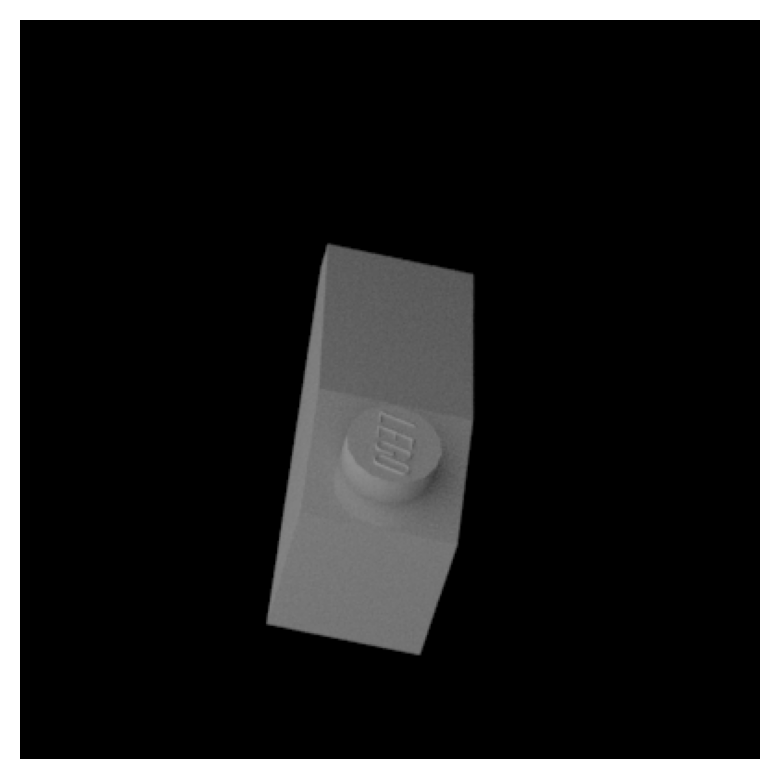

Example Compressed Image with shape torch.Size([3, 400, 400]):


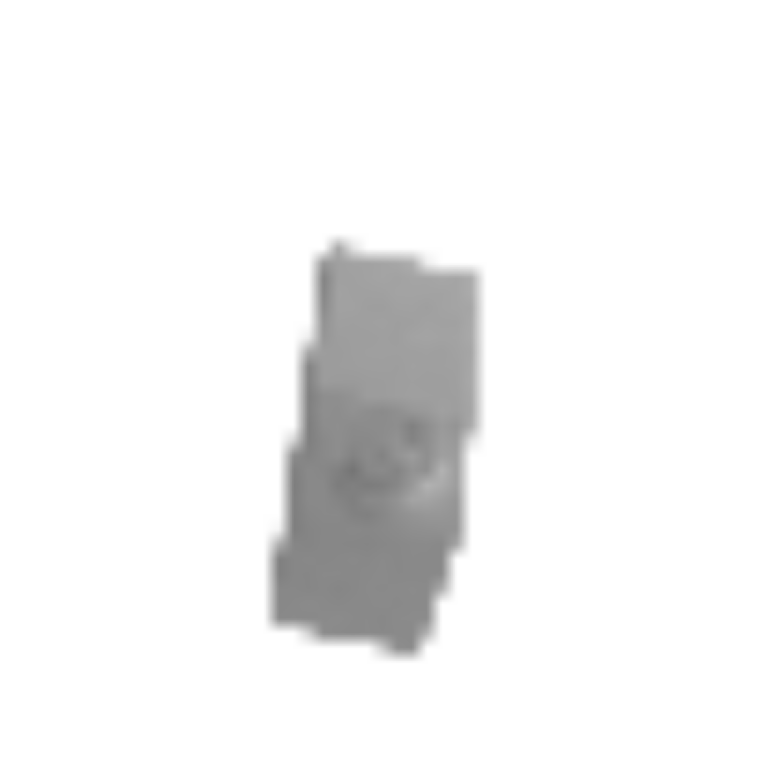

In [83]:
class Lego_Brick(Dataset):
    def __init__(self, root, train=True, transform=None, add_noise=True):
        self.train = train
        self.transform = transform
        self.img_list = glob.glob(os.path.join(root, '*.png'))
        self.add_noise = add_noise
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        img = Image.open(img_path)
        if self.transform is not None:
            img = self.transform(img)
        if self.add_noise:
            image = torch.flatten(img,0)
            mask = image <= 0
            noise = torch.randn(image.size()) * mask * 0.25
            image = image + noise
            return torch.unflatten(image,0,(3,400,400))
        return img

# initialize dataset
data = Lego_Brick('/kaggle/input/lego-brick-images/dataset', transform=transforms.ToTensor(),add_noise=False)
print(f"No. of images in LEGO dataset: {len(data)}")
# plot a random datapoint to see what our data looks like
test_image = data[random.randint(0, len(data))]
compressed_test = compress(test_image,16)
print(f"Example Image with shape {test_image.shape}:")
plot_image(test_image)
print(f"Example Compressed Image with shape {compressed_test.shape}:")
plot_image(compressed_test)

In [84]:
class Encoder(nn.Module):
    """This is the encoder class for your Autoencoder. The objective of the decoder is to take an 
    image of size (3, 64, 64) as input and produce a latent code (compressed representation) of 
    shape (N, latent_features).
    
    We recommend you start with a combination of 'nn.Conv2d' and 'nn.Linear' with `nn.ReLU` in 
    between. We used two Conv2d layers, followed by two Linear layers in our testing. Make sure you 
    `flatten` the output of a conv2d layer (if any) before passing it as an input to linear layer.

    Tip: Writing the expected input and output shapes after each layer in the comments helps. 
    """
    def __init__(self, input_features, num_features):
        super(Encoder, self).__init__()
        self.input_features = input_features  # this is the product of input dimensions, not the shape
        self.latent_features = num_features
        # TODO: initialize the Encoder network
        ####################################################
        self.layers = []
        self.layers.append(nn.Conv2d(3,num_features,8,stride=2))
        self.layers.append(nn.Tanh())
        for i in range(5):
            self.layers.append(nn.Conv2d(num_features,num_features,5))
            self.layers.append(nn.Tanh())
        self.encoder = nn.Sequential(*self.layers)
        

        ####################################################

    def forward(self, x):
        # TODO: Define the forward pass for the network,
        # you can reuse 'x' for the output
        ####################################################
        x=self.encoder(x)
        
        ####################################################
        return x

In [85]:
# let's test if it worked
input_features = 3*400*400
num_features = 32
# initialize encoder
encoder = Encoder(input_features, num_features)
# sample input
x = torch.rand((100, 3, 400, 400))

num_params = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
print(f"No. of trainable parameters: {num_params}")

# forward pass through encoder
z = encoder(x)
print(f"Input shape: {x.shape},\nZ shape: {z.shape}")
print("The expected size of the z vector is (batch_size, 32). Is it?")

No. of trainable parameters: 134336
Input shape: torch.Size([100, 3, 400, 400]),
Z shape: torch.Size([100, 32, 177, 177])
The expected size of the z vector is (batch_size, 32). Is it?


In [86]:
class Decoder(nn.Module):
    """This is the decoder class for your Autoencoder. The objective of the decoder is to take a 
    compressed representation (latent code) vector `z` of size (N, latent_features) and transform 
    it to an image tensor of size (N, 3, 64, 64), where N=batch_size.
    
    You can use a combination of `nn.Linear` and `nn.ConvTranspose2d` layers here, with `nn.ReLU` activations
    in between (everywhere but the end). We used 2 Linear layers followed by 2 ConvTranspose2d layers in our 
    testing, but you can use anything as long as the input and output shapes are accounted for. Make sure you 
    `unflatten` the output of a linear layer before passing it as an input to conv2d layer (if any).

    Tip: Writing the expected input and output shapes after each layer in the comments helps.    
    """
    def __init__(self, output_features, num_features):
        super(Decoder, self).__init__()
        self.output_features = output_features  # this is the product of output dimensions, not the shape
        self.latent_features = num_features
        # TODO: initialize the Decoder network
        ####################################################
        self.layers = []
        for i in range(5):
            self.layers.append(nn.ConvTranspose2d(num_features,num_features,5))
            self.layers.append(nn.Tanh())
        self.layers.append(nn.ConvTranspose2d(num_features,3,8,stride=2))
        self.decoder = nn.Sequential(*self.layers)
        ####################################################

    def forward(self, z):
        # TODO: Define the forward pass for the network, 
        # you can reuse 'z' for the output
        ####################################################
        
        z=self.decoder(z)
        
        ####################################################
        return z

In [87]:
# let's test if it worked
output_features = 3*400*400
num_features = 32
# initialize decoder
decoder = Decoder(output_features, num_features)
# sample input
z = torch.rand((100,num_features,177,177))

num_params = sum(p.numel() for p in decoder.parameters() if p.requires_grad)
print(f"No. of trainable parameters: {num_params}")

# forward pass through decoder
x_recon = decoder(z)
print(f"Input shape: {z.shape} \nOutput shape: {x_recon.shape}")
print("The expected size of the output is (batch_size, 3, 400, 400). Is it?")

No. of trainable parameters: 134307
Input shape: torch.Size([100, 32, 177, 177]) 
Output shape: torch.Size([100, 3, 400, 400])
The expected size of the output is (batch_size, 3, 400, 400). Is it?


In [16]:
class Autoencoder(nn.Module):

    """This will combine your encoder and decoder modules together
    with their powers combined and make an AUTOENCODER. We will also define loss functions here.
    You can choose any loss that compares the input and output directly, such as MSE, MAE, etc.
    
    Params:
        input_features   : the total number of input features to the network (int)
        latent_features  : the dimensionality of the latent code (compressed representation) (int)

    Inputs:
        X                : The input image. shape (N, 3, 64, 64)
        
    Outputs (dict):
        z                : The reparameterized sample produced by encoder. shape (N, latent_features)
        x_recon          : The reconstructed version of input X. shape (N, 3, 64, 64)
        loss             : reconstruction loss. (float)
    """

    def __init__(self, input_features, latent_features):
        super().__init__()
        
        self.input_features = self.output_features = input_features
        self.latent_features = latent_features

        self.encoder = Encoder(self.input_features, self.latent_features)
        self.decoder = Decoder(self.output_features, self.latent_features)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
        # TODO: fill out your chosen loss function here
        #############################################
#         self.loss = nn.MSELoss()
        self.loss = MSSSIM()
        #############################################

    def forward(self, x):
        x_compress = compress(x,8)
        z = self.encoder(x_compress) 
        x_recon = self.decoder(self.tanh(z))
        x_recon = self.relu(x_recon)
        # Add exp to lessen effect of blank space (make loss more dependent on the actual shape)
        loss = 1 - self.loss(self.sigmoid(x_recon), self.sigmoid(x))
        
        # .detach() just makes it so the backprop is cutoff here (anything we do past it won't affect the gradient)
        
        return {
            'z': z.detach(),  # this contains the latent encodings that we'll use to plot
            'x_recon': x_recon.detach(),  # this contains the reconstructed image
            'loss': loss,  # this is the loss that we'll use to train the network through backprop
            'x_compress': x_compress
        }

In [89]:
# initialize model and count number of trainable parameters
input_features = 3*400*400
latent_features = 32
model = Autoencoder(input_features, latent_features)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"No. of trainable parameters: {num_params}")
print("Warning! If your model has > 0.5M params, it might take really long to train!")

No. of trainable parameters: 268643
Warning! If your model has > 0.5M params, it might take really long to train!


Test image input:


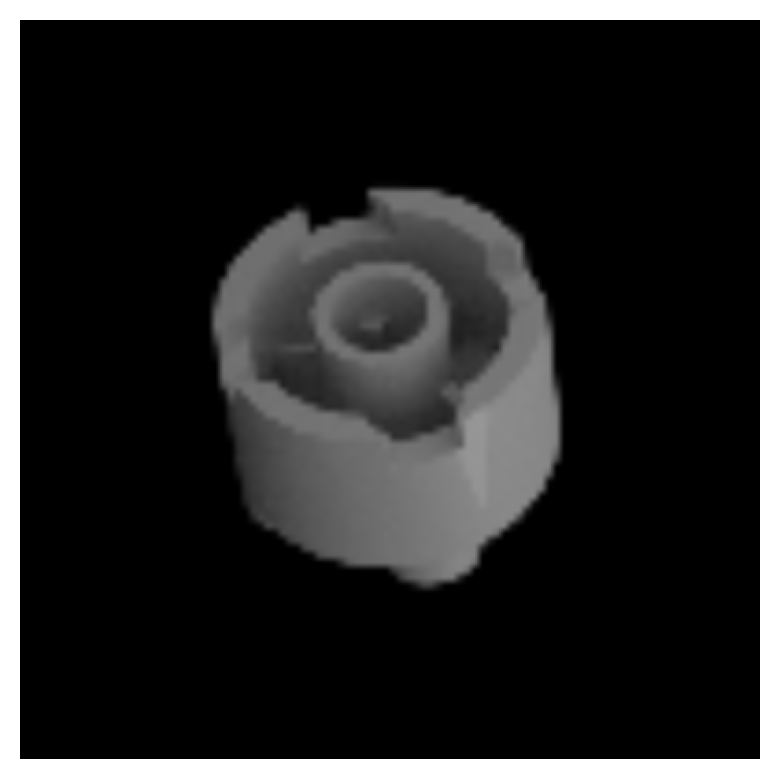

Test image reconstruction:


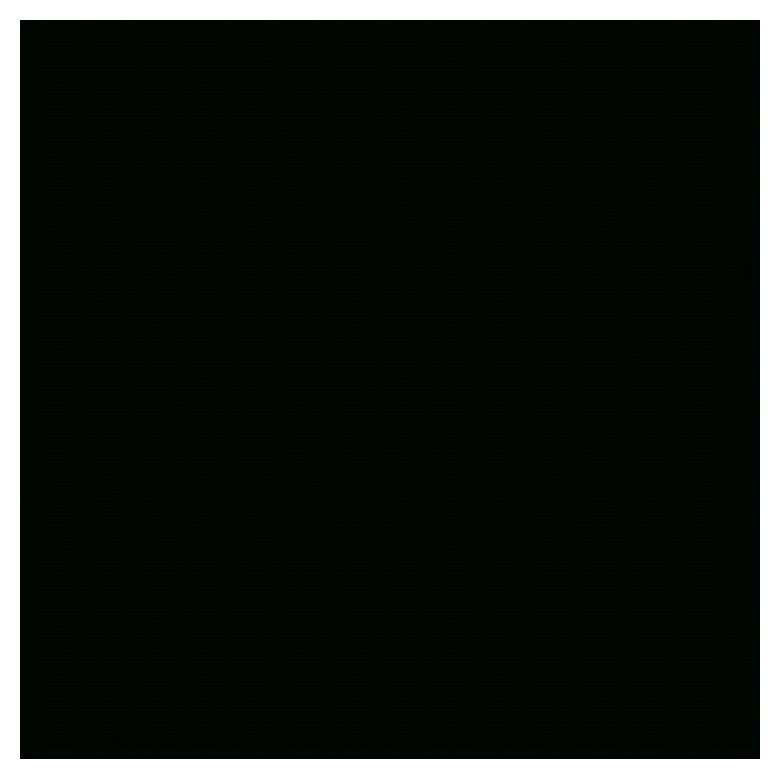

In [90]:
# Shows the prediction of the autoencoder without training

test_image = data[random.randint(0, len(data))]

print("Test image input:")
plot_image(compress(test_image,8))
model=model.to('cpu')
outputs = model(test_image.unsqueeze(0))

print("Test image reconstruction:")
plot_image(outputs['x_recon'].squeeze())

In [91]:
# Model and training parameters
input_features = 3 * 400 * 400  # do not change
# start with these parameters, and then play around with them
#############################################
latent_features = 32
lr = 1e-4
batch_size = 64
num_epochs = 15
#############################################

# Initialize model and move it to GPU
model = Autoencoder(input_features, latent_features)
model = model.to(device)

# Initialize dataset and dataloaders
# for this HW, we're gonna use a subset of the training data as test
# This is a really bad idea in practice, but sufficient for the purposes of this HW.
train_data = Lego_Brick('/kaggle/input/lego-brick-images/dataset', transform=transforms.ToTensor())
test_data = Lego_Brick('/kaggle/input/lego-brick-images/dataset', transform=transforms.ToTensor(), add_noise=False)
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
val_loader = DataLoader(test_data, batch_size=64, num_workers=1, shuffle=True, pin_memory=True)

# Initialize optimizer, you can use SGD, Adam, or anything else here
optimizer = optim.Adam(model.parameters(), lr=lr)

In [92]:
# Let's take things for a spin
# This checks that your model, loss and optimizer are valid
print("BEFORE GRADIENT STEP:")
test_image = data[random.randint(0, len(data))]
# we now need to move the input to the same device as the model (aka GPU)
test_image = test_image.unsqueeze(0).to(device)
output = model(test_image)

optimizer.zero_grad() # Sets the gradient to 0 so that gradients don't stack together

loss_before = output['loss']
print("loss: ", loss_before.item())

loss_before.backward() # This gets the gradient of the loss function w.r.t all of your model's params

print()
print("AFTER GRADIENT STEP:")
optimizer.step() # This takes the step to train

output = model(test_image)

loss_after = output['loss']
print("loss: ",loss_after.item())

print()
print("Difference in loss:", (loss_before - loss_after).item())
print("This should be some positive number to say we reduced loss")

BEFORE GRADIENT STEP:
loss:  0.18979567289352417

AFTER GRADIENT STEP:
loss:  0.18915808200836182

Difference in loss: 0.0006375908851623535
This should be some positive number to say we reduced loss


In [93]:
def train_autoencoder(model, train_loader, val_loader, optimizer, epochs=1, seed=42, path=None):
    """Updates the parameters of the given model using the optimizer of choice to
    reduce the given loss_function. This will iterate over the dataloader `epochs` times
    training on each batch of images.
    
    There are 4 steps you need to complete here:
        (1) Reset the optimizer, so that gradients are zeroed out. Hint: use .zero_grad()
        (2) Forward pass: call the model on a batch of inputs `batch_x`.
        (3) Backward pass: use the `loss` key in the returned dict. Hint: use .backward()
        (4) Take a step in the direction of the -ve gradient. Hint: use .step()
    """
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed(seed)

    # set up tracking parameters
    plot_interval = 1
    history = {'loss': [],}
    vis = Visualizer(
        figsize=(16, 7),
        loss_xlim=(0, epochs),
        plot_interval=plot_interval,
    )
    
    # run the training loop
    print("Started training... (first epoch can take a while)")
    for epoch in range(epochs):
        model = model.train()  # set the model to training mode
        for batch_idx, batch_x in (enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"))):
            batch_x = batch_x.to(device)  # ensures the input is on the same device as the model
            # TODO Complete the training loop using the instructions above
            # Hint: the following code essentially does one training step
            #############################################
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = outputs['loss']
            loss.backward()
            optimizer.step()
            
            #############################################

        # validation
        if epoch % plot_interval == 0:
            test_autoencoder(model, val_loader, history, vis)
    test_autoencoder(model, val_loader, history, vis, path)        
    return model


@torch.no_grad()  # this makes sure that we don't accumulate gradients during testing phase
def test_autoencoder(model, val_loader, history, vis, path=None):
    model = model.eval()  # set the model to evaluation mode
    batch_x = next(iter(val_loader)).to(device)  # only use 2000 examples for test
    
    loss_dict = model(batch_x)  # run forward pass on test examples
    
    # record metrics and images for plotting
    history['loss'].append(loss_dict['loss'].item())
    x_recon = loss_dict['x_recon']

    # plot the results
    vis.plot(compress(batch_x,12),batch_x, x_recon, loss_dict['z'].cpu().numpy(), history, path=path)

In [94]:
print(model.encoder.encoder)
print(model.decoder.decoder)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(2, 2))
  (1): Tanh()
  (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (3): Tanh()
  (4): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (5): Tanh()
  (6): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (7): Tanh()
  (8): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (9): Tanh()
  (10): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (11): Tanh()
)
Sequential(
  (0): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (3): Tanh()
  (4): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (5): Tanh()
  (6): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (7): Tanh()
  (8): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (9): Tanh()
  (10): ConvTranspose2d(32, 3, kernel_size=(8, 8), stride=(2, 2))
)


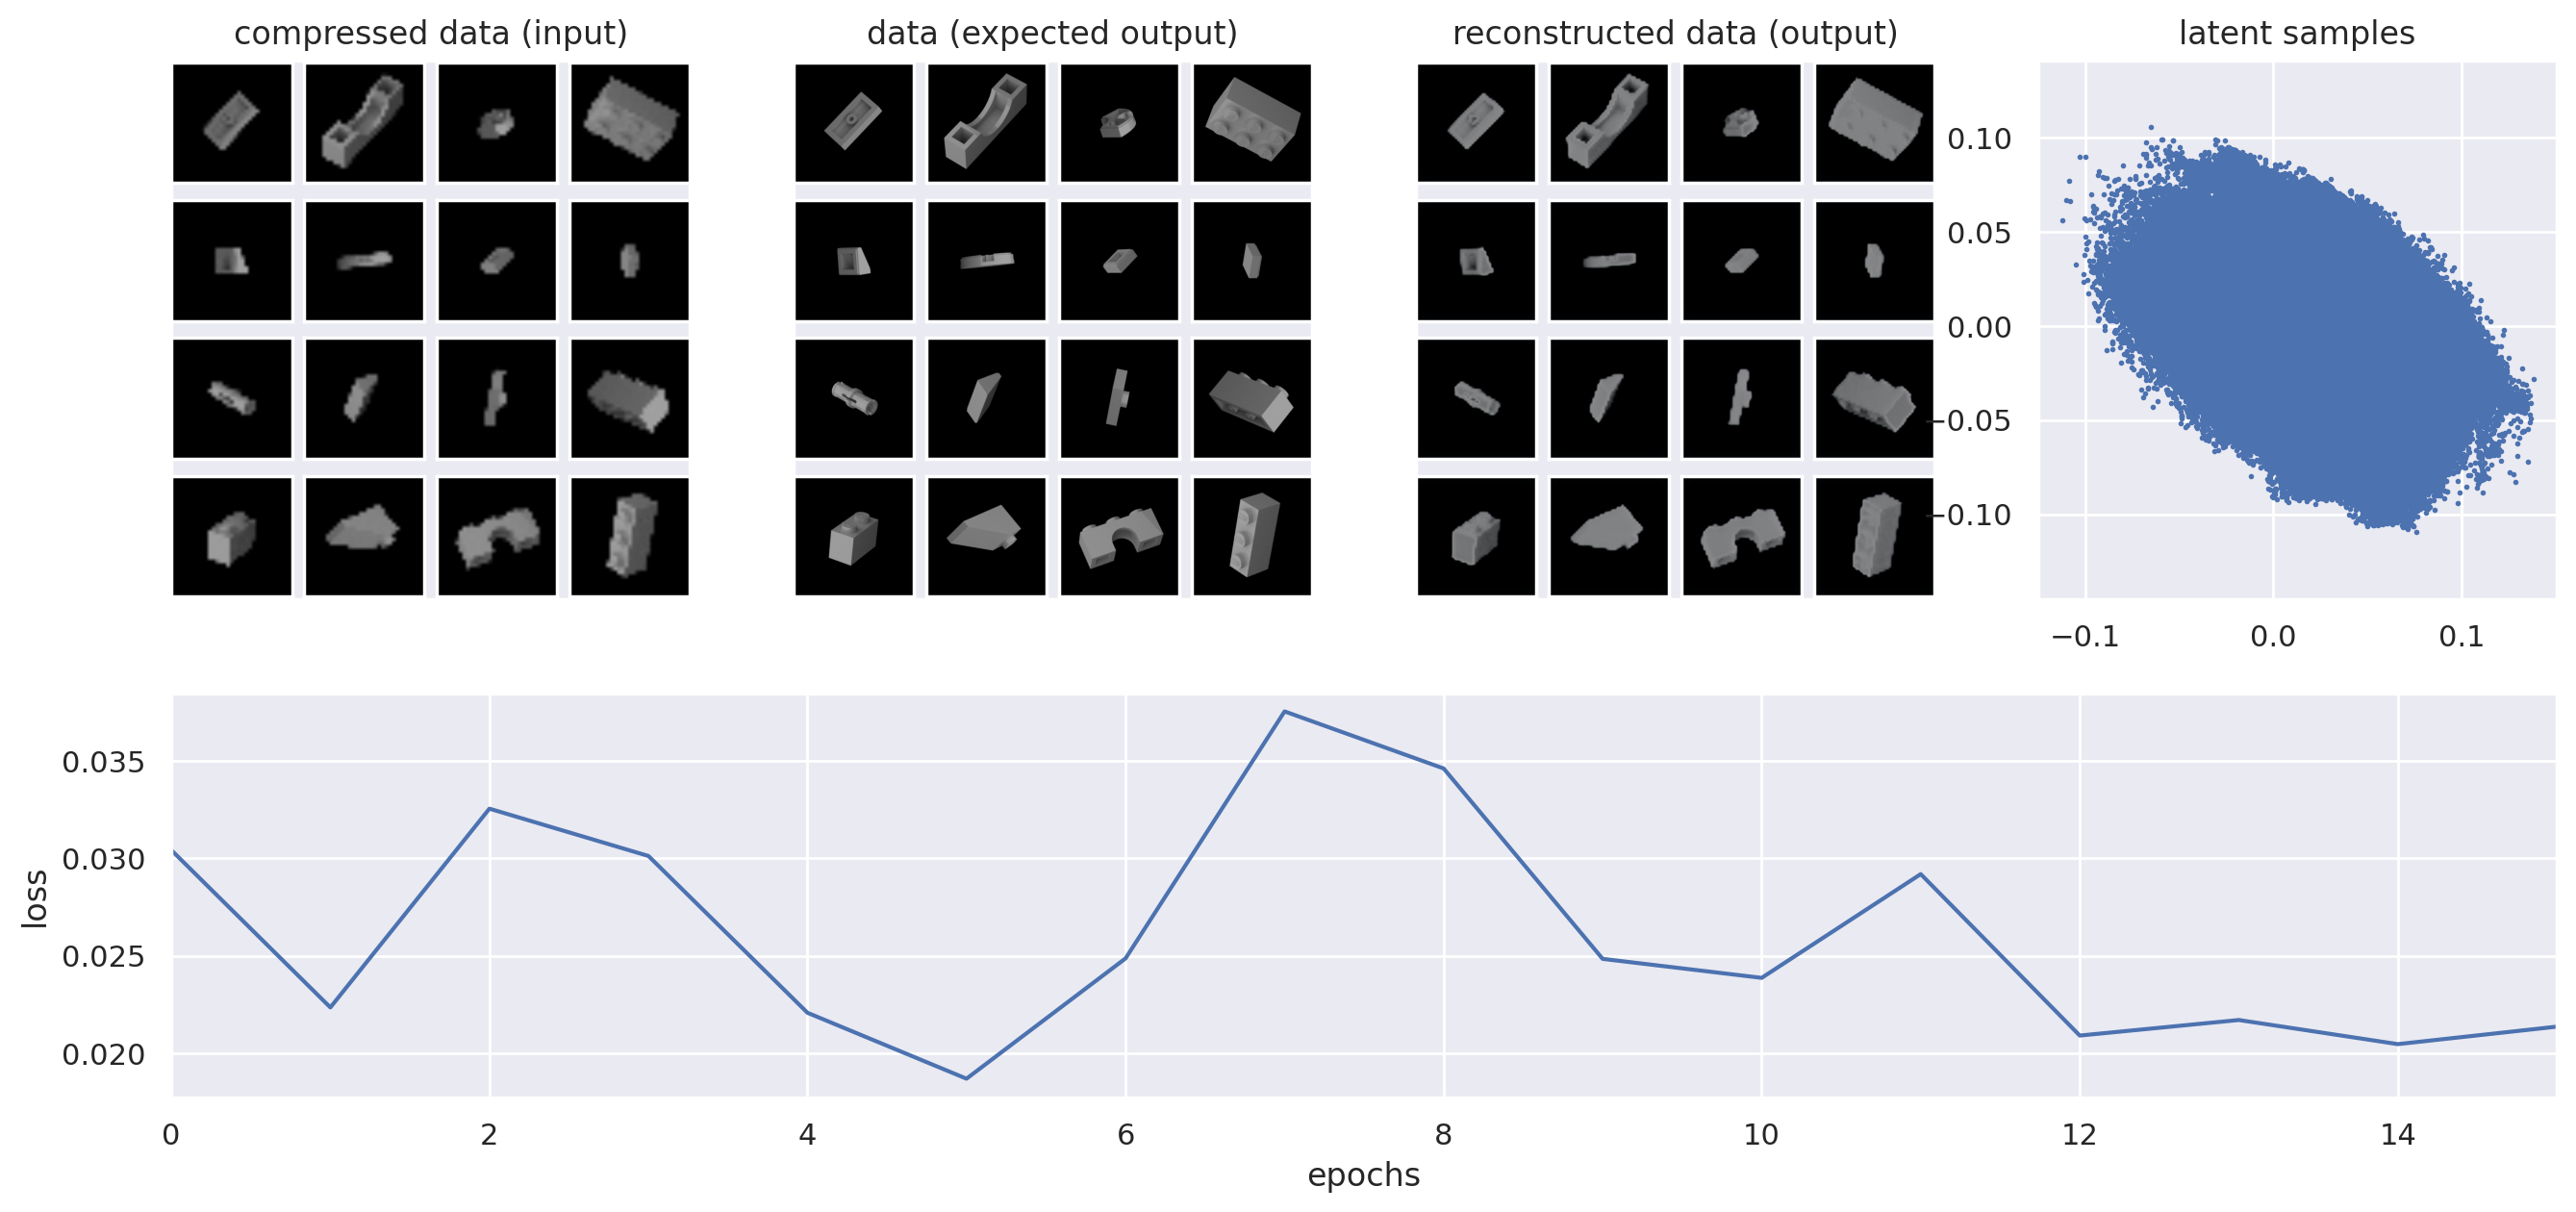

Finished Training. Time taken: 7870.11s
Saving weights to: 0_72.pt


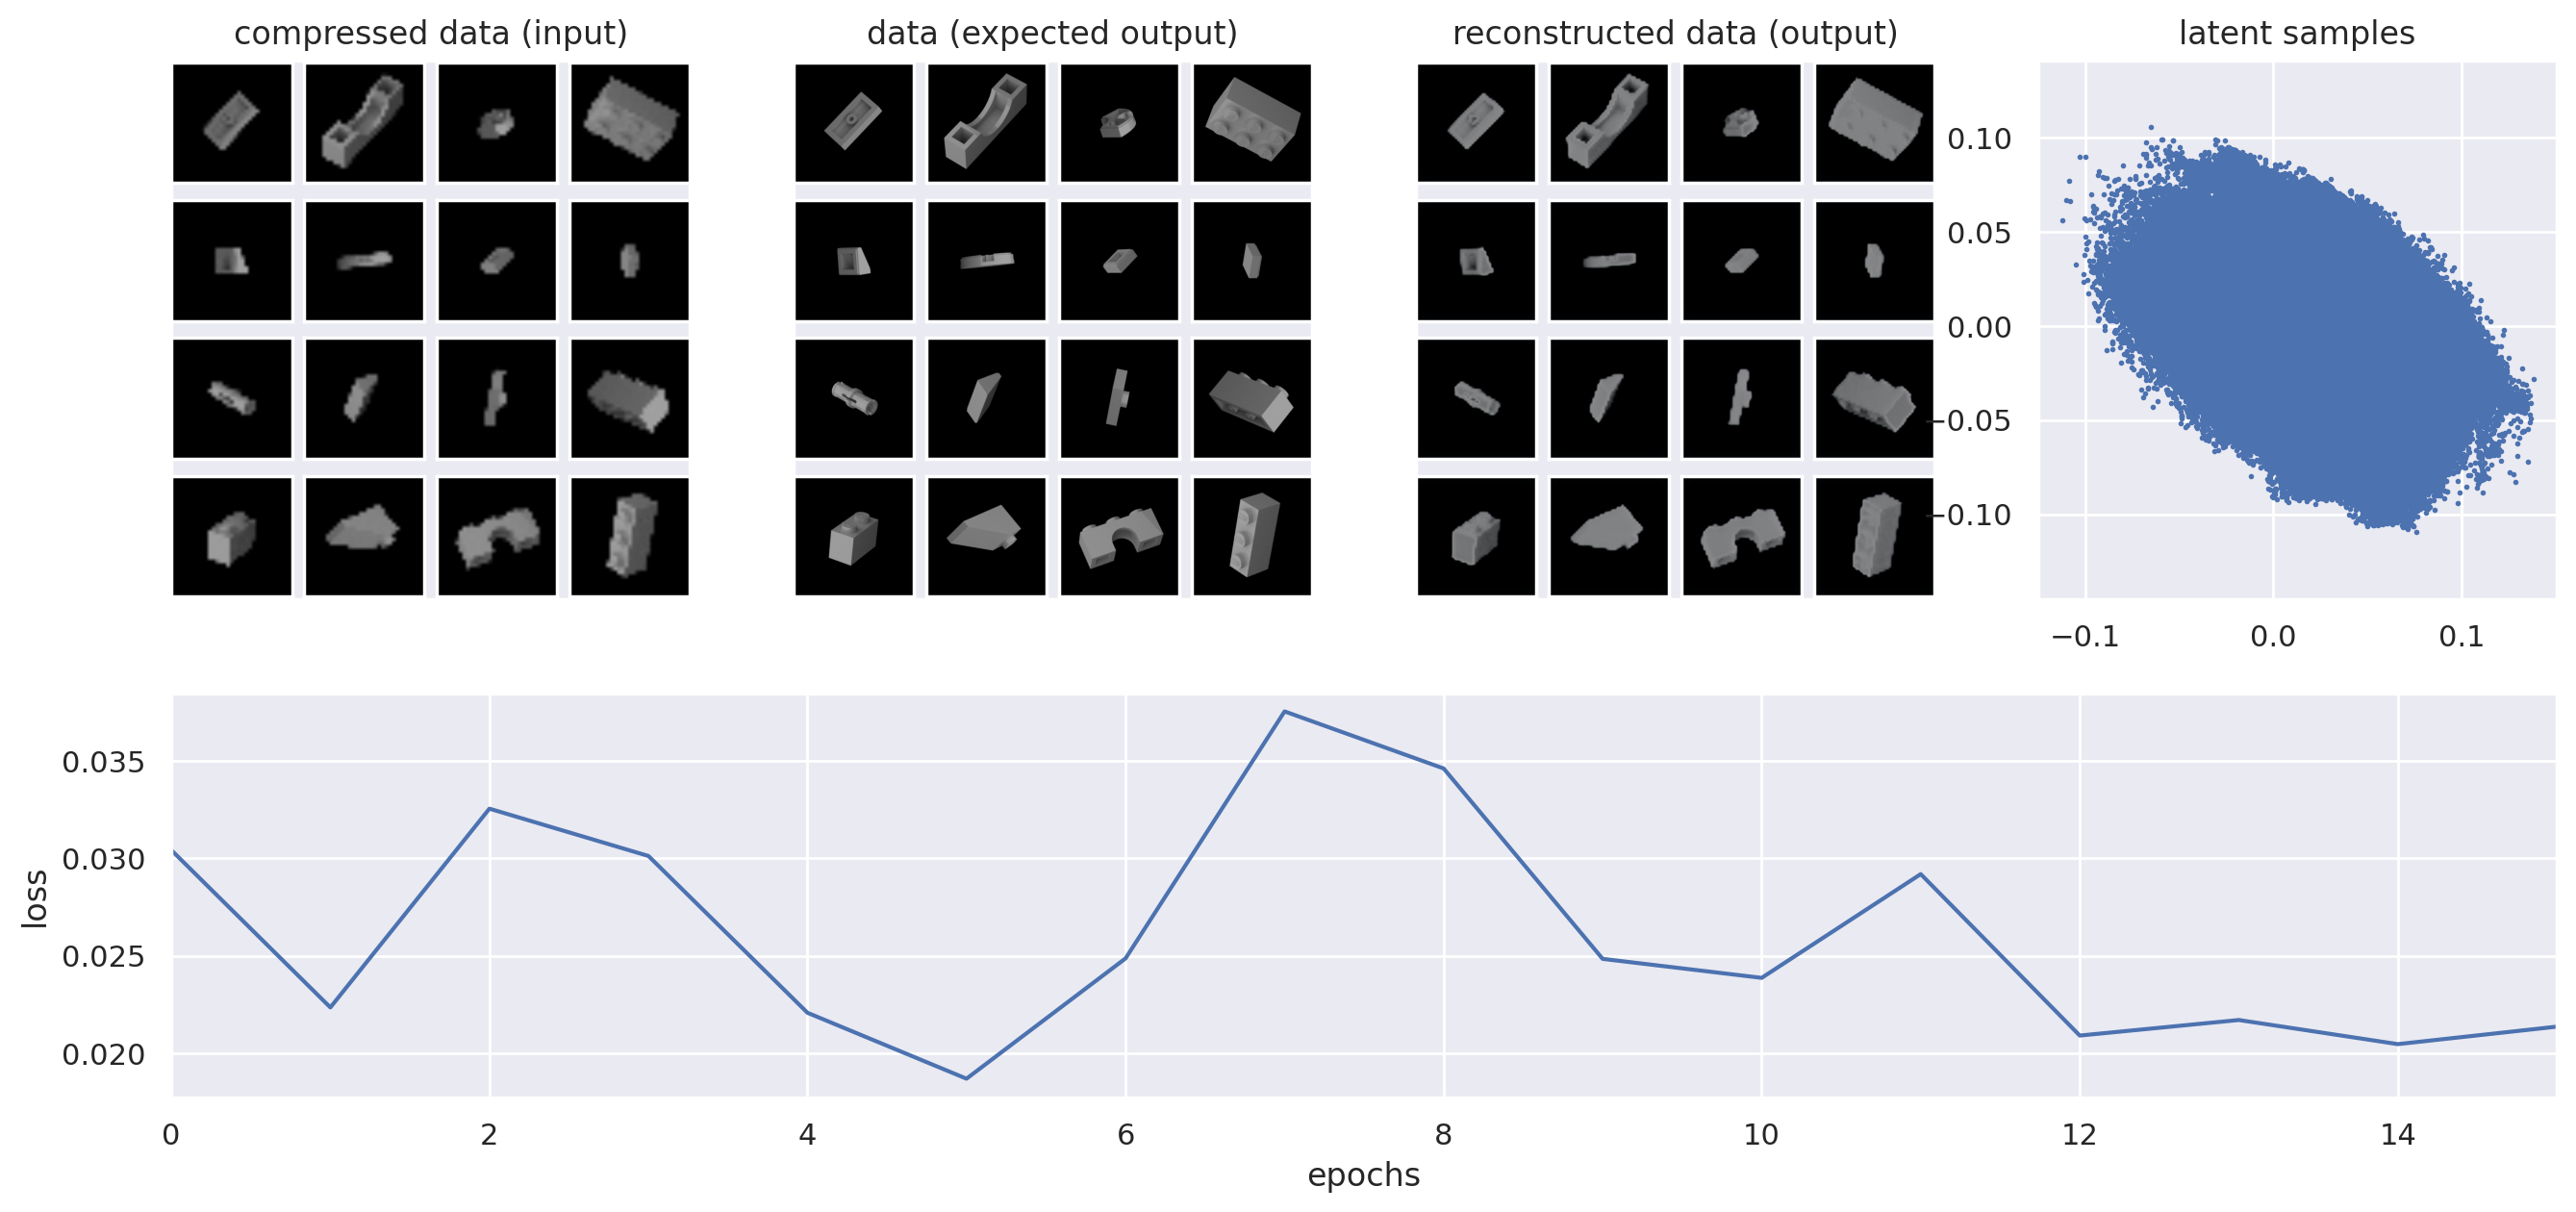

In [95]:
# Run the training! Important: Reset your model and optimizers before starting the training. 
# remember that this can take anywhere between 15 mins to the heat death of the universe depending on the size of your model, 
# so be patient (and if you're looking like you're on the heat death of the unvierse side of things, maybe make your model smaller).

# to save model weights after training, define a path to store the weights
weights_path = '/kaggle/working/celeba_ae10d.pt'
assert not os.path.exists(weights_path), f"{weights_path} already exists, choose a new name unless you wish to overwrite weights"
lrs = np.random.randint(1,500,size=1)
for i, lr in enumerate(lrs):
    path = f'{i}_{lr}'
    weights_path = f'{path}.pt'
    lr = lr * 1e-6
    print(path)
    model = Autoencoder(input_features, latent_features)
    model = model.to(device)

    # Initialize dataset and dataloaders
    # for this HW, we're gonna use a subset of the training data as test
    # This is a really bad idea in practice, but sufficient for the purposes of this HW.
    train_data = Lego_Brick('/kaggle/input/lego-brick-images/dataset', transform=transforms.ToTensor())
    test_data = Lego_Brick('/kaggle/input/lego-brick-images/dataset', transform=transforms.ToTensor(), add_noise=False)
    train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
    val_loader = DataLoader(test_data, batch_size=64, num_workers=1, shuffle=True, pin_memory=True)

    # Initialize optimizer, you can use SGD, Adam, or anything else here
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Start training!
    tic = time.time()
    model = train_autoencoder(model, train_loader, val_loader, optimizer, num_epochs, seed=3, path=f'{path}.png')
    toc = time.time()
    print(f"Finished Training. Time taken: {toc-tic:.2f}s")

    # save weights after training
    print(f"Saving weights to: {weights_path}")
    torch.save(model.state_dict(), weights_path)

Test image input:


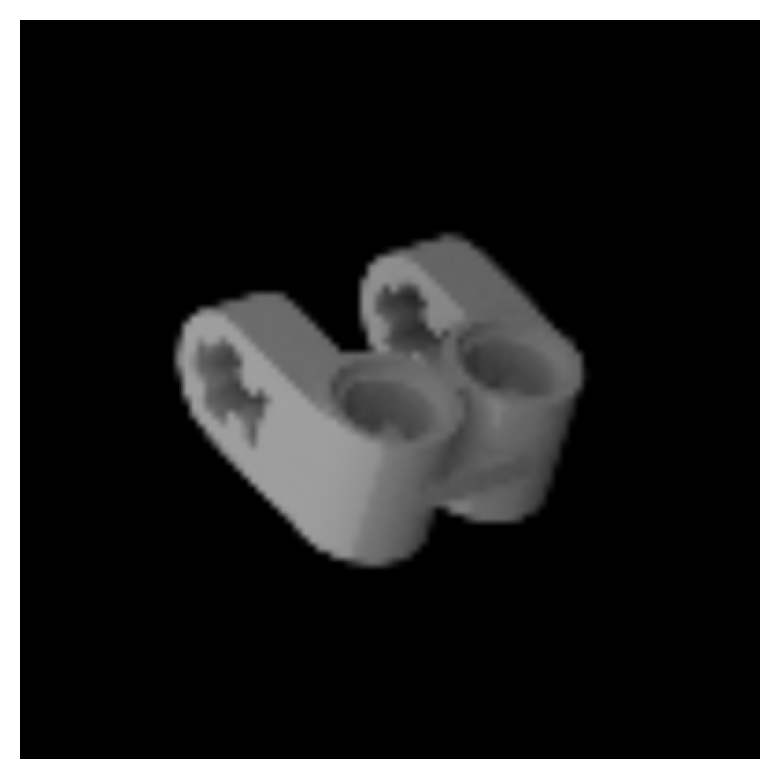

Test image reconstruction:


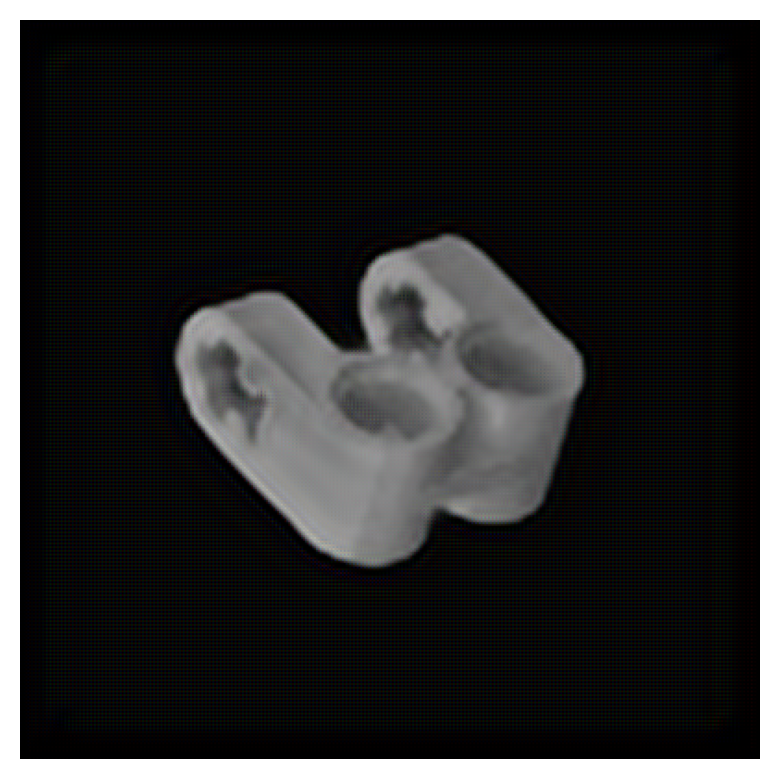

In [92]:
filename = '3_103.pt'
model_path = f'/kaggle/input/past-models/{filename}'
model = Autoencoder(3*400*400, 32)
model.load_state_dict(torch.load(model_path))
model.eval()

data = Lego_Brick('/kaggle/input/lego-brick-images/dataset', transform=transforms.ToTensor(), add_noise=False)
# data = Lego_Brick('/kaggle/input/license-plate-characters-detection-ocr/LP-characters/images', transform=transforms.ToTensor(),add_noise=False)

test_image = data[random.randint(0, len(data))]
test_image = transforms.Resize((400,400))(test_image)

model=model.to('cpu')
outputs = model(test_image.unsqueeze(0))
print("Test image input:")
plot_image(outputs['x_compress'].squeeze())

print("Test image reconstruction:")
plot_image(outputs['x_recon'].squeeze())